In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from prophet import Prophet

PROJECT_ROOT = Path(r"C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting")

OUTPUT_DIR = PROJECT_ROOT / "output" / "clean"
IMAGES_DIR = PROJECT_ROOT / "images" / "dtw"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

print("OUTPUT_DIR:", OUTPUT_DIR)
print("IMAGES_DIR:", IMAGES_DIR)


Importing plotly failed. Interactive plots will not work.


OUTPUT_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean
IMAGES_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\dtw


In [2]:
dtw_path = OUTPUT_DIR / "delta_dtw.csv"
print("Loading:", dtw_path)

df_dtw = pd.read_csv(dtw_path)
df_dtw.columns = [c.lower() for c in df_dtw.columns]

df_dtw["date"] = pd.to_datetime(df_dtw["date"])
df_dtw["pax"]  = df_dtw["passengers_domestic"] + df_dtw["passengers_international"]

df_dtw = df_dtw.sort_values("date").reset_index(drop=True)
df_dtw[["date", "pax"]].head()


Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_dtw.csv


,date,pax
0,2002-10-01,NaN
1,2002-11-01,NaN
2,2002-12-01,27504.0
3,2003-01-01,20080.0
4,2003-02-01,23234.0


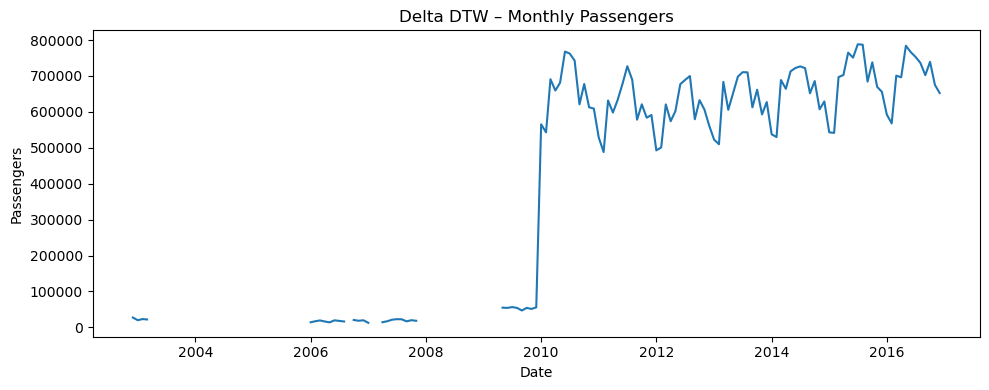

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df_dtw["date"], df_dtw["pax"])
plt.title("Delta DTW – Monthly Passengers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.tight_layout()
plt.show()


In [4]:
df_prophet = df_dtw[["date", "pax"]].rename(columns={"date": "ds", "pax": "y"})
df_prophet = df_prophet.sort_values("ds")
df_prophet.head()


,ds,y
0,2002-10-01,NaN
1,2002-11-01,NaN
2,2002-12-01,27504.0
3,2003-01-01,20080.0
4,2003-02-01,23234.0


In [5]:
test_horizon = 24

split_index = len(df_prophet) - test_horizon
train_df = df_prophet.iloc[:split_index].copy()
test_df  = df_prophet.iloc[split_index:].copy()

print("Train:", train_df["ds"].min(), "→", train_df["ds"].max())
print("Test :", test_df["ds"].min(),  "→", test_df["ds"].max())


Train: 2002-10-01 00:00:00 → 2015-03-01 00:00:00
Test : 2015-04-01 00:00:00 → 2017-03-01 00:00:00


In [6]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

m.fit(train_df)

future = m.make_future_dataframe(periods=test_horizon, freq="MS")
forecast = m.predict(future)

merged = df_prophet.merge(forecast[["ds","yhat"]], on="ds", how="left")
test_merged = merged.iloc[split_index:]

y_true = test_merged["y"].values
y_pred = test_merged["yhat"].values

mae  = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

print(f"DTW Backtest Metrics (24-month holdout)")
print(f"  MAE : {mae:,.0f}")
print(f"  RMSE: {rmse:,.0f}")
print(f"  MAPE: {mape:.2f}%")


13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:44 - cmdstanpy - INFO - Chain [1] done processing


DTW Backtest Metrics (24-month holdout)
  MAE : nan
  RMSE: nan
  MAPE: nan%


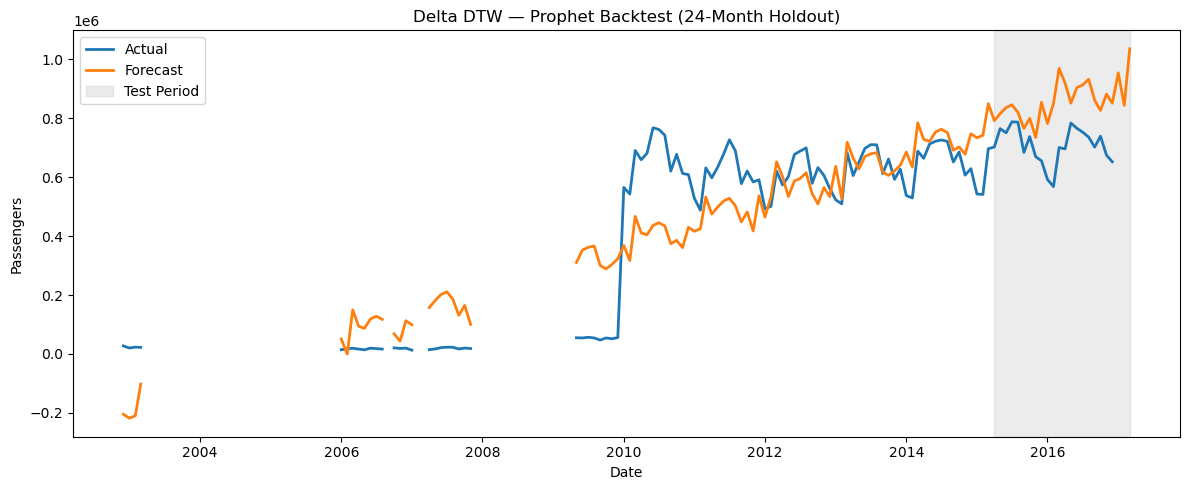

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\dtw\dtw_passengers_backtest.png


In [7]:
plt.figure(figsize=(12,5))
plt.plot(merged["ds"], merged["y"], label="Actual", linewidth=2)
plt.plot(merged["ds"], merged["yhat"], label="Forecast", linewidth=2)

plt.axvspan(test_df["ds"].min(), test_df["ds"].max(),
            color="grey", alpha=0.15, label="Test Period")

plt.title("Delta DTW — Prophet Backtest (24-Month Holdout)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()

out_path = IMAGES_DIR / "dtw_passengers_backtest.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [8]:
m_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

m_full.fit(df_prophet)

future_full = m_full.make_future_dataframe(periods=36, freq="MS")
forecast_full = m_full.predict(future_full)

forecast_full.tail()


13:13:57 - cmdstanpy - INFO - Chain [1] start processing
13:13:57 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
149,2019-08-01,1.015958e+06,854469.519546,1.249049e+06,1.015958e+06,1.015958e+06,30502.074607,30502.074607,30502.074607,30502.074607,30502.074607,30502.074607,0.0,0.0,0.0,1.046460e+06
150,2019-09-01,1.021764e+06,791884.654193,1.190211e+06,1.021764e+06,1.021764e+06,-34484.926541,-34484.926541,-34484.926541,-34484.926541,-34484.926541,-34484.926541,0.0,0.0,0.0,9.872793e+05
151,2019-10-01,1.027383e+06,814671.527950,1.203547e+06,1.027383e+06,1.027383e+06,-32615.436607,-32615.436607,-32615.436607,-32615.436607,-32615.436607,-32615.436607,0.0,0.0,0.0,9.947679e+05
152,2019-11-01,1.033190e+06,763834.779581,1.162990e+06,1.033190e+06,1.033190e+06,-61048.142211,-61048.142211,-61048.142211,-61048.142211,-61048.142211,-61048.142211,0.0,0.0,0.0,9.721415e+05
153,2019-12-01,1.038809e+06,821193.725799,1.204713e+06,1.038809e+06,1.038809e+06,-30405.979890,-30405.979890,-30405.979890,-30405.979890,-30405.979890,-30405.979890,0.0,0.0,0.0,1.008403e+06


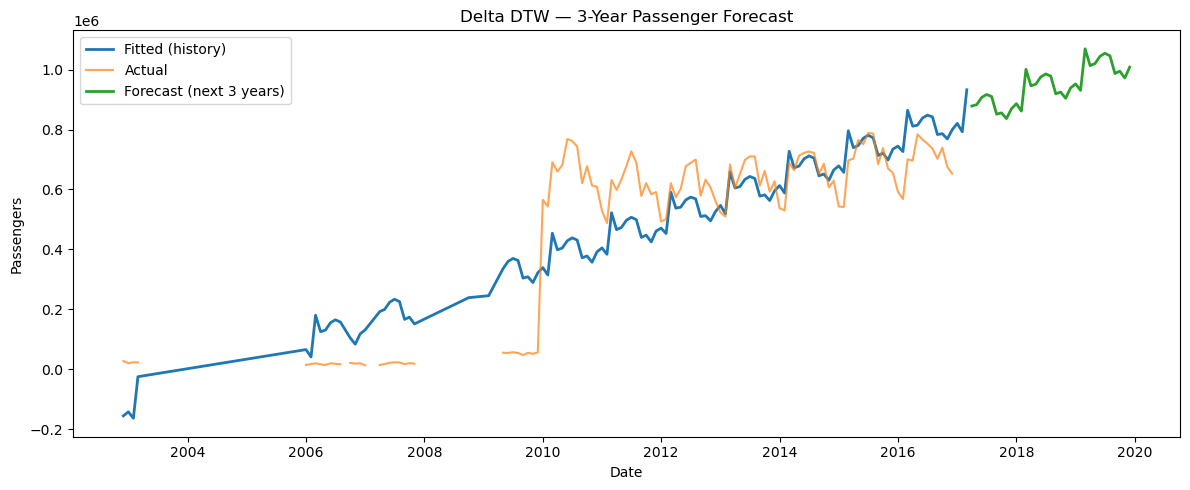

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\dtw\dtw_passengers_3year_forecast.png


In [9]:
plt.figure(figsize=(12,5))

hist   = forecast_full[forecast_full["ds"] <= df_prophet["ds"].max()]
future = forecast_full[forecast_full["ds"] > df_prophet["ds"].max()]

plt.plot(hist["ds"], hist["yhat"], label="Fitted (history)", linewidth=2)
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual", linewidth=1.5, alpha=0.7)
plt.plot(future["ds"], future["yhat"], label="Forecast (next 3 years)", linewidth=2)

plt.title("Delta DTW — 3-Year Passenger Forecast")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.tight_layout()

out_path = IMAGES_DIR / "dtw_passengers_3year_forecast.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Seb\anaconda3\envs\aviation\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. 

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\dtw\dtw_passengers_components.png


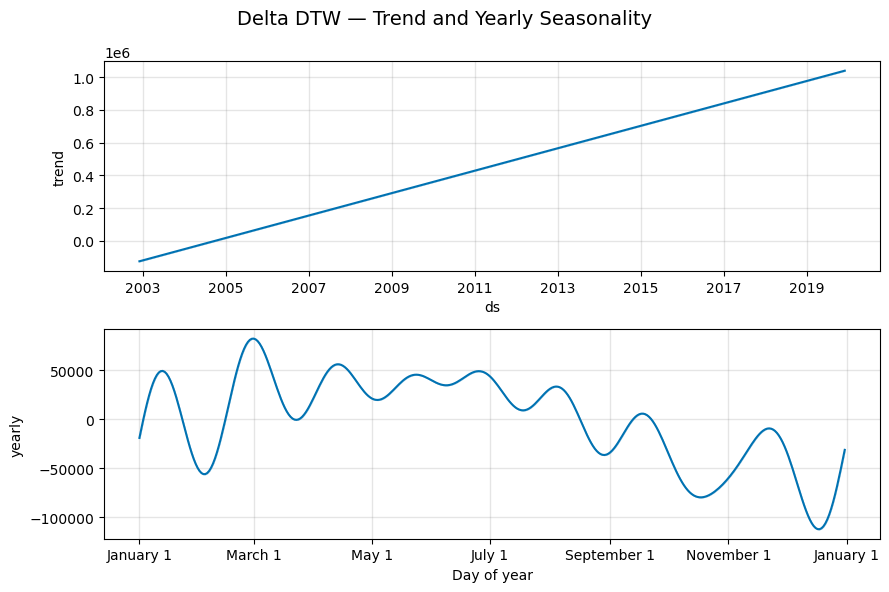

In [10]:
fig = m_full.plot_components(forecast_full)
fig.suptitle("Delta DTW — Trend and Yearly Seasonality", fontsize=14)
plt.tight_layout()

out_path = IMAGES_DIR / "dtw_passengers_components.png"
fig.savefig(out_path, dpi=300)
print("Saved:", out_path)
